In [ ]:
!pip install --quiet neo4j langchain-community langchain-core langchain-openai langchain-text-splitters tiktoken wikipedia

In [1]:
import asyncio
import getpass
import os
from datetime import datetime
from hashlib import md5
from typing import Dict, List

import pandas as pd
import seaborn as sns
import tiktoken
from langchain_community.graphs import Neo4jGraph
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_text_splitters import TokenTextSplitter
from pydantic import BaseModel, Field

/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"

graph = Neo4jGraph(refresh_schema=False)

graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:Chunk) REQUIRE c.id IS UNIQUE")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:AtomicFact) REQUIRE c.id IS UNIQUE")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:KeyElement) REQUIRE c.id IS UNIQUE")
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (d:Document) REQUIRE d.id IS UNIQUE")

[]

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key: ········


In [4]:
wikipedia = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=10000)
)
text = wikipedia.run("Joan of Arc")


In [5]:
construction_system = """
You are now an intelligent assistant tasked with meticulously extracting both key elements and
atomic facts from a long text.
1. Key Elements: The essential nouns (e.g., characters, times, events, places, numbers), verbs (e.g.,
actions), and adjectives (e.g., states, feelings) that are pivotal to the text’s narrative.
2. Atomic Facts: The smallest, indivisible facts, presented as concise sentences. These include
propositions, theories, existences, concepts, and implicit elements like logic, causality, event
sequences, interpersonal relationships, timelines, etc.
Requirements:
#####
1. Ensure that all identified key elements are reflected within the corresponding atomic facts.
2. You should extract key elements and atomic facts comprehensively, especially those that are
important and potentially query-worthy and do not leave out details.
3. Whenever applicable, replace pronouns with their specific noun counterparts (e.g., change I, He,
She to actual names).
4. Ensure that the key elements and atomic facts you extract are presented in the same language as
the original text (e.g., English or Chinese).
"""

construction_human = """Use the given format to extract information from the 
following input: {input}"""

construction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            construction_system,
        ),
        (
            "human",
            (
                "Use the given format to extract information from the "
                "following input: {input}"
            ),
        ),
    ]
)

class AtomicFact(BaseModel):
    key_elements: List[str] = Field(description="""The essential nouns (e.g., characters, times, events, places, numbers), verbs (e.g.,
actions), and adjectives (e.g., states, feelings) that are pivotal to the atomic fact's narrative.""")
    atomic_fact: str = Field(description="""The smallest, indivisible facts, presented as concise sentences. These include
propositions, theories, existences, concepts, and implicit elements like logic, causality, event
sequences, interpersonal relationships, timelines, etc.""")

class Extraction(BaseModel):
    atomic_facts: List[AtomicFact] = Field(description="List of atomic facts")

model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0.1)
structured_llm = model.with_structured_output(Extraction)

construction_chain = construction_prompt | structured_llm

In [6]:
import_query = """
MERGE (d:Document {id:$document_name})
WITH d
UNWIND $data AS row
MERGE (c:Chunk {id: row.chunk_id})
SET c.text = row.chunk_text,
    c.index = row.index,
    c.document_name = row.document_name
MERGE (d)-[:HAS_CHUNK]->(c)
WITH c, row
UNWIND row.atomic_facts AS af
MERGE (a:AtomicFact {id: af.id})
SET a.text = af.atomic_fact
MERGE (c)-[:HAS_ATOMIC_FACT]->(a)
WITH c, a, af
UNWIND af.key_elements AS ke
MERGE (k:KeyElement {id: ke})
MERGE (a)-[:HAS_KEY_ELEMENT]->(k)
"""

def encode_md5(text):
    return md5(text.encode("utf-8")).hexdigest()

In [7]:
# Paper used 2k token size
async def process_document(text, document_name, chunk_size=2000, chunk_overlap=200):
    start = datetime.now()
    print(f"Started extraction at: {start}")
    text_splitter = TokenTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    texts = text_splitter.split_text(text)
    print(f"Total text chunks: {len(texts)}")
    tasks = [
        asyncio.create_task(construction_chain.ainvoke({"input":chunk_text}))
        for index, chunk_text in enumerate(texts)
    ]
    results = await asyncio.gather(*tasks)
    print(f"Finished LLM extraction after: {datetime.now() - start}")
    docs = [el.dict() for el in results]
    for index, doc in enumerate(docs):
        doc['chunk_id'] = encode_md5(texts[index])
        doc['chunk_text'] = texts[index]
        doc['index'] = index
        for af in doc["atomic_facts"]:
            af["id"] = encode_md5(af["atomic_fact"])
    # Import chunks/atomic facts/key elements
    graph.query(import_query, 
            params={"data": docs, "document_name": document_name})
    # Create next relationships between chunks
    graph.query("""MATCH (c:Chunk)<-[:HAS_CHUNK]-(d:Document)
WHERE d.id = $document_name
WITH c ORDER BY c.index WITH collect(c) AS nodes
UNWIND range(0, size(nodes) -2) AS index
WITH nodes[index] AS start, nodes[index + 1] AS end
MERGE (start)-[:NEXT]->(end)
""",
           params={"document_name":document_name})
    print(f"Finished import at: {datetime.now() - start}")

In [8]:
await process_document(text, "Joan of Arc", chunk_size=500, chunk_overlap=100)

Started extraction at: 2024-09-20 14:59:10.326386
Total text chunks: 4
Finished LLM extraction after: 0:00:12.764439
Finished import at: 0:00:12.824348


<Axes: xlabel='tokens', ylabel='Count'>

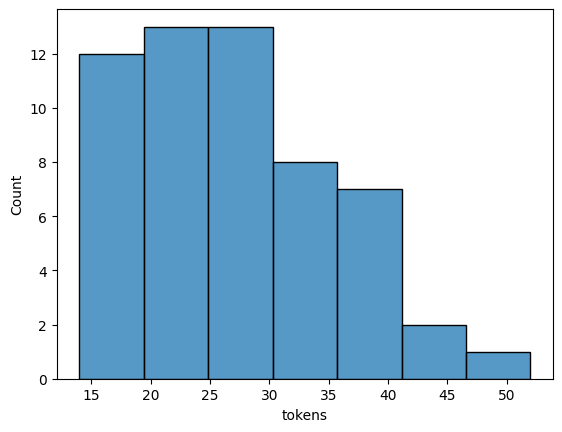

In [9]:
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model("gpt-4")
    num_tokens = len(encoding.encode(string))
    return num_tokens


atomic_facts = graph.query("MATCH (a:AtomicFact) RETURN a.text AS text")
df = pd.DataFrame.from_records(
    [{"tokens": num_tokens_from_string(el["text"])} for el in atomic_facts]
)

sns.histplot(df["tokens"])

In [10]:
graph.query("""MATCH (a:AtomicFact) 
RETURN a.text AS text
ORDER BY size(text) ASC LIMIT 3
UNION ALL
MATCH (a:AtomicFact) 
RETURN a.text AS text
ORDER BY size(text) DESC LIMIT 3""")

[{'text': 'In 1920, Joan of Arc was canonized by Pope Benedict XV.'},
 {'text': 'Joan of Arc was captured by Burgundian troops on 23 May.'},
 {'text': 'The film is known for its cinematography and use of close-ups.'},
 {'text': "Joan of Arc was put on trial by Bishop Pierre Cauchon on accusations of heresy, including blaspheming by wearing men's clothes, acting upon visions that were demonic, and refusing to submit her words and deeds to the judgment of the church."},
 {'text': 'In 1428, Joan of Arc requested to be taken to Charles VII, testifying that she was guided by visions from the archangel Michael, Saint Margaret, and Saint Catherine to help save France from English domination.'},
 {'text': "The accusations against Joan of Arc included blaspheming by wearing men's clothes, acting upon visions that were demonic, and refusing to submit her words and deeds to the judgment of the church."}]

<Axes: xlabel='key', ylabel='connections'>

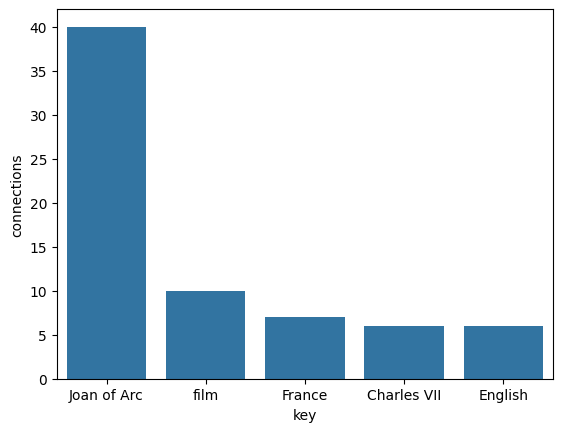

In [11]:
data = graph.query("""
MATCH (a:KeyElement) 
RETURN a.id AS key, 
       count{(a)<-[:HAS_KEY_ELEMENT]-()} AS connections
ORDER BY connections DESC LIMIT 5""")
df = pd.DataFrame.from_records(data)
sns.barplot(df, x='key', y='connections')